In [1]:
import pandas as pd
import seaborn as sns
import os
import gc
sns.set_theme()

In [2]:
lotus = pd.read_csv("./data/230106_frozen_metadata.csv.gz", low_memory=False)
lotus = lotus.rename(columns={'organism_name': 'species', 'structure_smiles_2D': 'molecule'})

In [3]:
lotus.organism_taxonomy_01domain

0         Eukaryota
1         Eukaryota
2         Eukaryota
3         Eukaryota
4         Eukaryota
            ...    
792359    Eukaryota
792360    Eukaryota
792361    Eukaryota
792362    Eukaryota
792363    Eukaryota
Name: organism_taxonomy_01domain, Length: 792364, dtype: object

In [4]:
directory = './out/'
dataframes = []  # List to hold dataframes
for filename in os.listdir(directory):
    if filename.endswith('.parquet'):  # Ensures only parquet files are read
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)  # Read parquet file to a pandas df
        dataframes.append(df)  # Append the df to the list
df = pd.concat(dataframes, ignore_index=True)

df.prob = df.prob.astype('float32')

In [5]:
pivot_df = df.pivot_table(index='species', columns='molecule', values='prob')
del df

In [6]:
#pivot_df

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
species_std = scaler.fit_transform(pivot_df)

Text(0, 0.5, 'PC2 (11.16% of variance)')

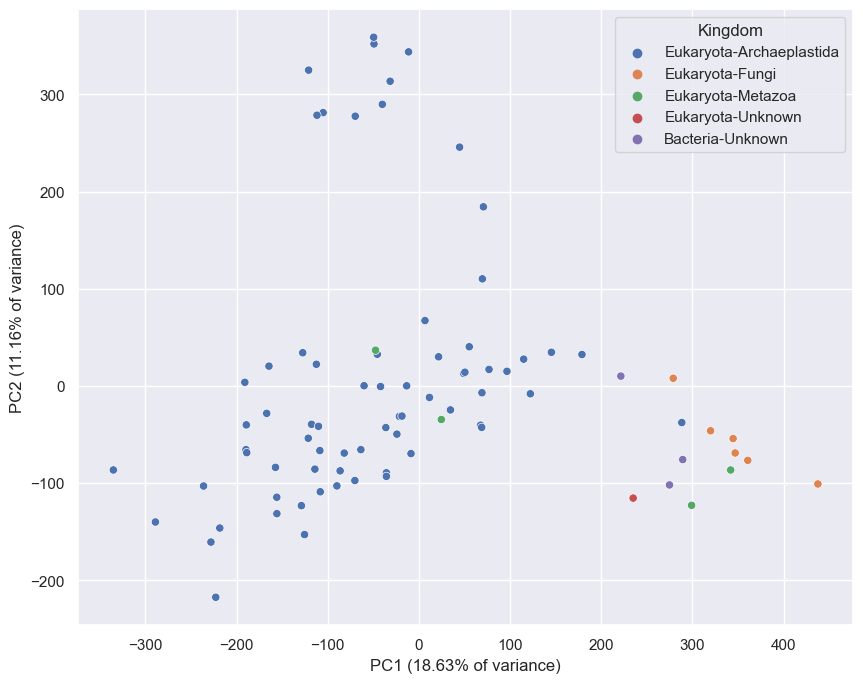

In [9]:
# Initialize PCA
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(species_std)

# Create a DataFrame from PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['species'] = pivot_df.index  # Add species column from the index of pivot_df

# Merge the kingdom information into the PCA results dataframe
pca_df = pd.merge(pca_df, lotus[['species',
                                 'organism_taxonomy_02kingdom',
                                'organism_taxonomy_01domain']], on='species', how='left').drop_duplicates()
pca_df['organism_taxonomy_02kingdom'] = pca_df['organism_taxonomy_02kingdom'].fillna('Unknown')

pca_df['domain_kingdom'] = pca_df['organism_taxonomy_01domain'] + "-" + pca_df['organism_taxonomy_02kingdom']

plt.figure(figsize=(10,8))
scatter = sns.scatterplot(data=pca_df, x=pca_df['PC1'], y=pca_df['PC2'], hue='domain_kingdom')
# Set legend title
scatter.legend(title='Kingdom')
# Set axis labels with explained variance
plt.xlabel(
    'PC1 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[0]))
plt.ylabel(
    'PC2 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[1]))

# Add species names to the plot
#for line in range(0, pca_df.shape[0]):
#     plt.text(pca_df['PC1'][line], pca_df['PC2'][line], pca_df['species'][line], horizontalalignment='left', size='small', color='black')

In [10]:
#scatter.get_figure().savefig("test.png")

In [12]:
lotus.organism_taxonomy_01domain.unique()

array(['Eukaryota', nan, 'Bacteria', 'Archaea'], dtype=object)